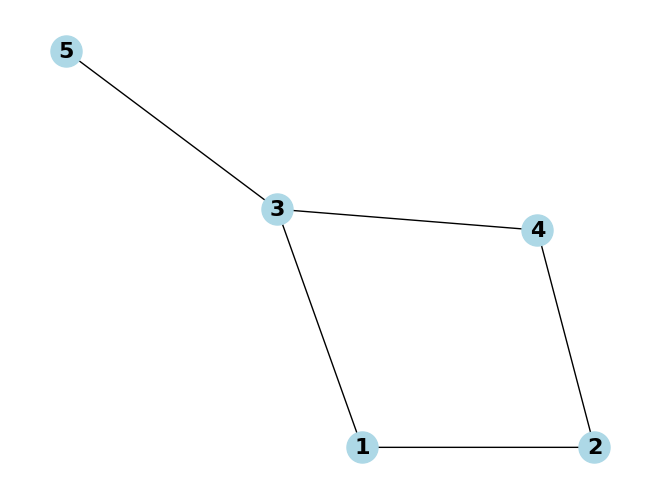

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)

# Add edges to the graph
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (3, 5)]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=16, font_weight='bold')

# Show the graph
plt.axis('off')
plt.show()

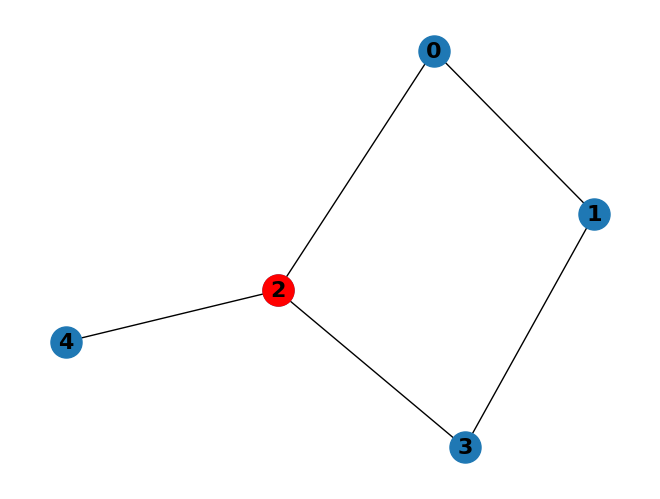

Current node: [0], Reward: 0.0, Done: False


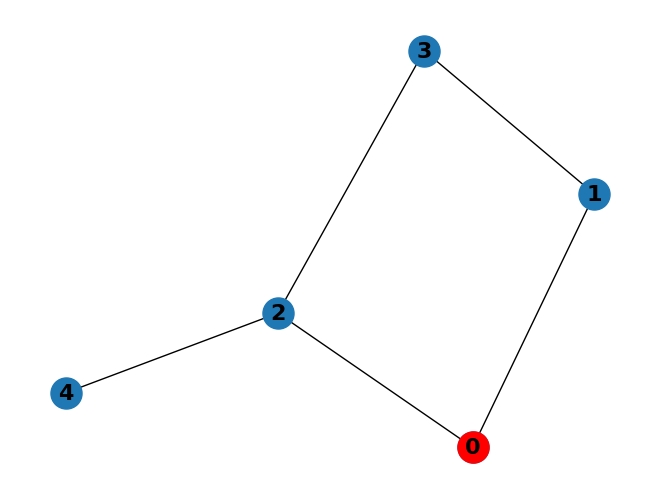

Current node: [2], Reward: 0.0, Done: False


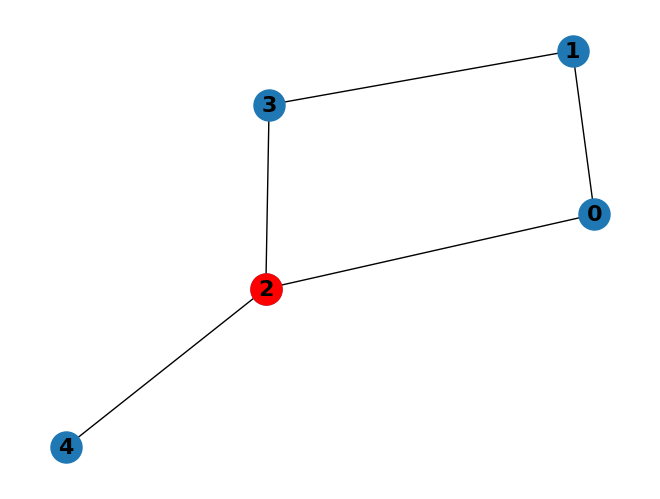

Current node: [0], Reward: 0.0, Done: False


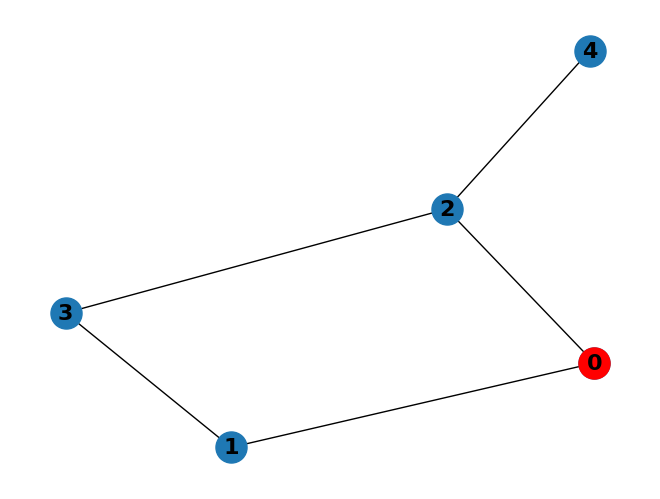

Current node: [2], Reward: 0.0, Done: False


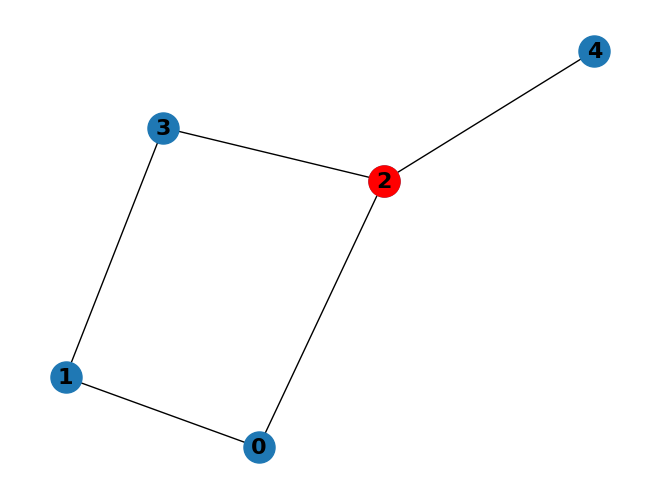

Current node: [0], Reward: 0.0, Done: False


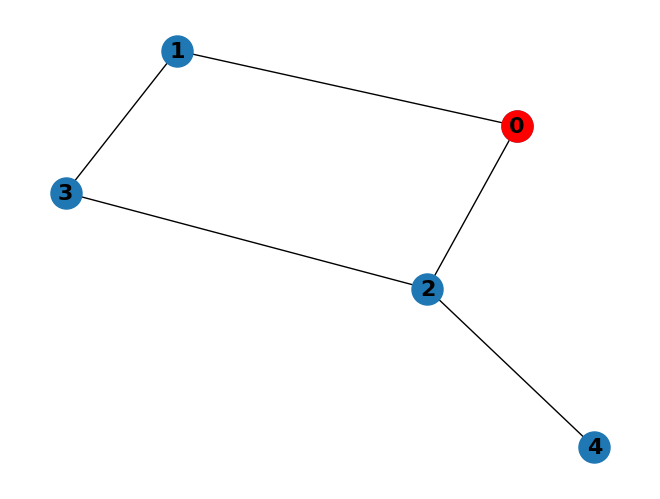

Current node: [1], Reward: 1.0, Done: True


In [10]:
import gym
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class GraphEnv(gym.Env):
    def __init__(self, graph):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.num_nodes = len(self.nodes)
        self.observation_space = gym.spaces.Discrete(self.num_nodes)
        self.action_space = gym.spaces.Discrete(self.num_nodes)
        self.current_node = None
        self.end_node = None

    def reset(self, start_node=None, end_node=None):
        if start_node is None:
            self.current_node = np.random.choice(self.nodes)
        else:
            self.current_node = start_node
        if end_node is None:
            self.end_node = np.random.choice(self.nodes)
        else:
            self.end_node = end_node
        return np.array([self.current_node])

    def step(self, action):
        if action in self.graph.neighbors(self.current_node):
            self.current_node = action
            if self.current_node == self.end_node:
                reward = 1.0
                done = True
            else:
                reward = 0.0
                done = False
        else:
            reward = -1.0
            done = False
        return np.array([self.current_node]), reward, done, {}

    def render(self, mode='human'):
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=500, font_size=16, font_weight='bold')
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.current_node], node_color='red', node_size=500)
        plt.axis('off')
        plt.show()

# Create the graph
G = nx.Graph()
nodes = [0, 1, 2, 3, 4]
G.add_nodes_from(nodes)
edges = [(0, 1), (0, 2), (1, 3), (2, 3), (2, 4)]
G.add_edges_from(edges)

# Create the gym environment
env = GraphEnv(G)

# Example usage
start_node = 2
end_node = 1
obs = env.reset(start_node, end_node)
done = False
while not done:
    env.render()

    action = np.random.choice(list(G.neighbors(obs[0])))
    obs, reward, done, _ = env.step(action)
    print(f"Current node: {obs}, Reward: {reward}, Done: {done}")

In [5]:
def generate_expert_trajectories(graph, num_trajectories):
    expert_trajectories = []
    for _ in range(num_trajectories):
        start_node = np.random.choice(list(graph.nodes()))
        end_node = np.random.choice(list(graph.nodes()))
        while start_node == end_node:
            end_node = np.random.choice(list(graph.nodes()))
        path = nx.shortest_path(graph, source=start_node, target=end_node)
        trajectory = []
        for i in range(len(path) - 1):
            obs = np.array([path[i]])
            action = path[i + 1]
            trajectory.append((obs, action))
            print(f"Observation: {obs}, Action: {action}")
        expert_trajectories.append(trajectory)
    return expert_trajectories

In [ ]:
def render_path(graph, path, pos):
    nx.draw(graph, pos, with_labels=True, node_size=500, font_size=16, font_weight='bold')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.axis('off')
    plt.show()

Expert Path 1: [0, 2, 4]
Expert Path 2: [1, 3]
Expert Path 3: [2, 3]
Expert Path 4: [3, 1, 0]
Expert Path 5: [1, 3]
Rendering Sample Path 1: [0, 2, 4]


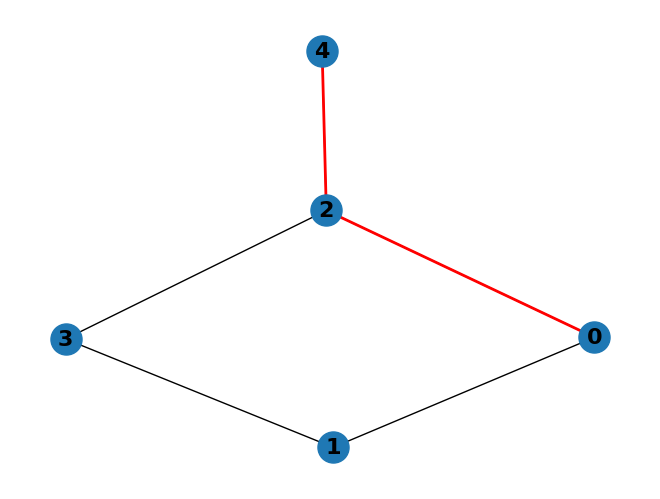

Rendering Sample Path 2: [2, 3]


/var/folders/p3/_7x95kts1j3536nntzbxcf_00000gn/T/ipykernel_74915/1350214942.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)


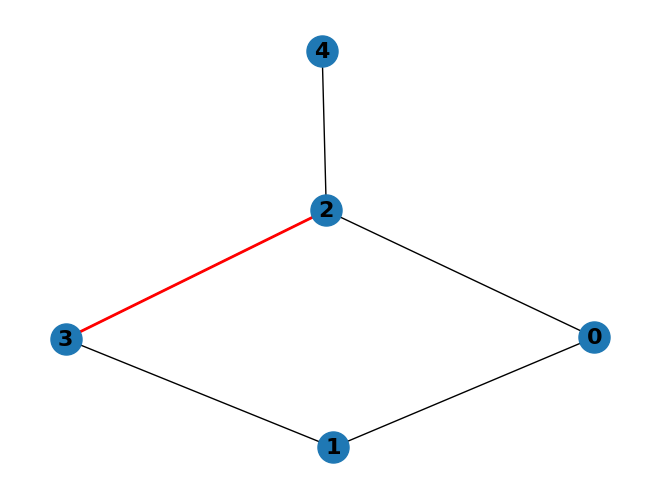

Rendering Sample Path 3: [3, 1, 0]


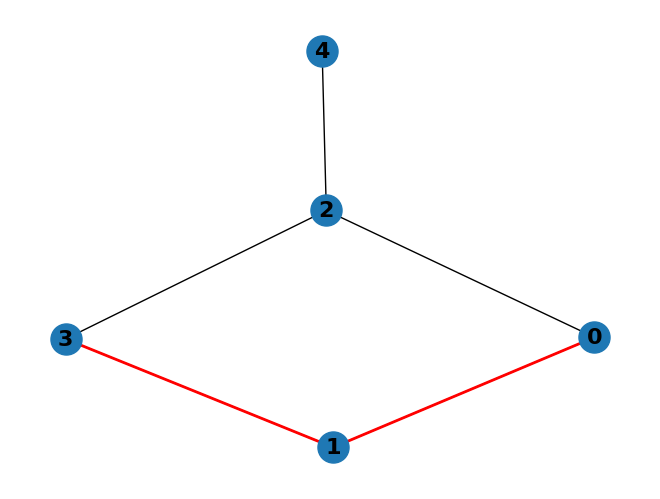

In [ ]:
# Generate expert paths
num_expert_paths = 5
expert_paths = generate_expert_paths(G, num_expert_paths)

# Print the expert paths
for i, path in enumerate(expert_paths):
    print(f"Expert Path {i+1}: {path}")

# Render sample paths
num_sample_paths = 3
sample_paths = [expert_paths[i] for i in np.random.choice(len(expert_paths), size=num_sample_paths, replace=False)]
pos = nx.spring_layout(G)
for i, path in enumerate(sample_paths):
    print(f"Rendering Sample Path {i+1}: {path}")
    render_path(G, path, pos)

In [ ]:
from imitation.algorithms.mce_irl import MCEIRL, mce_occupancy_measures, mce_partition_fh, TabularPolicy
from imitation.data import rollout
from imitation.util.util import make_vec_env

In [ ]:
vec_env = make_vec_env(lambda: env, n_envs=1, rng=np.random.default_rng())

# Generate expert paths
num_expert_paths = 100
expert_paths = generate_expert_paths(G, num_expert_paths)

# Convert expert paths to trajectories
expert_trajs = []
for path in expert_paths:
    obs = []
    actions = []
    rewards = []
    for i in range(len(path) - 1):
        state = path[i]
        action = path[i+1]
        obs.append(state)
        actions.append(action)
        rewards.append(0)  # Placeholder reward, not used in MCE-IRL
    obs.append(path[-1])
    expert_trajs.append(rollout.Trajectory(obs=np.array(obs), actions=np.array(actions), rewards=np.array(rewards)))

# Apply MCE-IRL
mce_irl = MCEIRL(env.observation_space.n, env.action_space.n)
reward_matrix = mce_irl.fit(expert_trajs)

# Print the learned reward function
print("Learned Reward Function:")
for state in range(env.observation_space.n):
    print(f"State {state}: {reward_matrix[state]:.4f}")

# Render sample paths
num_sample_paths = 3
sample_paths = [expert_paths[i] for i in np.random.choice(len(expert_paths), size=num_sample_paths, replace=False)]
pos = nx.spring_layout(G)
for i, path in enumerate(sample_paths):
    print(f"Rendering Sample Path {i+1}: {path}")
    render_path(G, path, pos)

AssertionError: 